In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [6]:
import tools

# pyforce

In [3]:
import sys
sys.path.append('../research/pyforce/')

In [191]:
from importlib import reload

import pyforce
pyforce = reload(pyforce)

The expression for the stress to optimise is:

$stress(X) = \sum_{i<j}w_{ij}(||X_i - X_j|| - d_{ij})^2$

$w_{ij} = d_{ij}^{-2}$

$||X_i - X_j||$ is a norm computed in the low-dimensional embedding and $d_{ij}$ is the pairwise distance in the high-dimensional embedding.

The gradient for this cost is equal to:

$grad_i(stress(X_i)) = \sum_j \frac{||X_i - X_j|| - d_{ij}}{||X_i - X_j||} \frac{X_i - X_j}{d_{ij}^2}$

# MNIST 2k

We start with the small version of the dataset MNIST:

<table>
    <tr>
        <th># of samples</th>
        <th># of classes</th>
        <th>dimensions</th>
    </tr>
    <tr>
        <td>1797</td>
        <td>10</td>
        <td>64</td>
    </tr>
</table>

This dataset is small enough to allow for a simple computation of the forces/gradient without requiring to prune the number of neighbhours taken into consideration.

In [201]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-2k')

and compute the pairwise distances:

In [202]:
pdist = Distances(X_train)

We will look at two different type of initialisation and compute the stress for each initial embeddings:

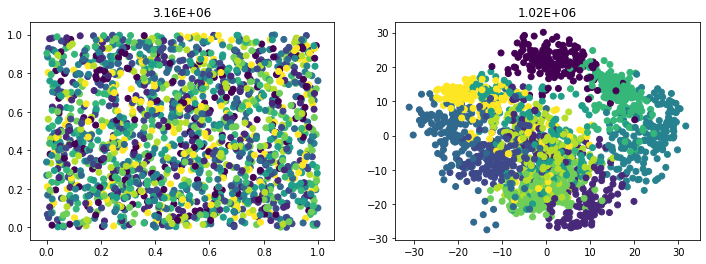

In [206]:
emb = np.random.random((X_train.shape[0], 2))
fe_rnd = ForceEmbedding(emb, pdist)

from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X_train)
fe_pca = ForceEmbedding(pca, pdist)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(emb[:,0], emb[:,1], c=y_train)
ax[0].set_title("{:.2E}".format(fe_rnd.stress()))

ax[1].scatter(pca[:,0], pca[:,1], c=y_train)
_=ax[1].set_title("{:.2E}".format(fe_pca.stress()))

We can now optimise the layout for 100 iterations and plot the stress throughout:

In [204]:
%time fe_pca.optimize(100)

CPU times: user 1min 26s, sys: 8.41 s, total: 1min 34s
Wall time: 23.8 s


ForceEmbedding([[ 6.42733674e+140, -4.19071391e+140],
                [ 1.19284739e+139,  1.54292938e+141],
                [-2.33675226e+139,  2.39090802e+141],
                ...,
                [ 3.02177165e+139,  6.93400560e+141],
                [-3.90625602e+138, -2.58348840e+141],
                [ 3.89368736e+139,  9.55451694e+141]])

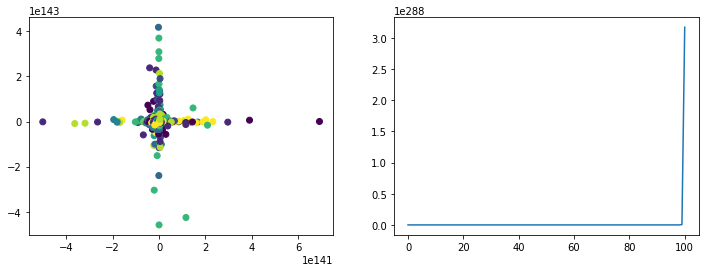

In [205]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(fe_pca[:,0], fe_pca[:,1], c=y_train)
ax[1].plot(np.array(fe_pca.error))

# random init

In [60]:
fe = ForceEmbedding(emb, pdist)

In [61]:
fe.stress()

3155236.8967847964

## PCA init

In [207]:
emb = np.random.random((X_train.shape[0], 2))

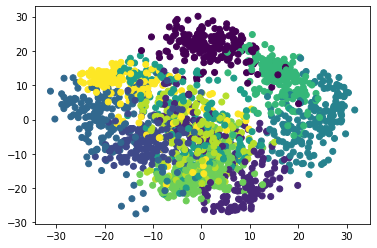

In [208]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X_train)
plt.scatter(pca[:,0], pca[:,1], c=y_train)

In [209]:
fe = ForceEmbedding(pca, pdist)

In [210]:
fe.stress()

1015957.5614521939

In [211]:
%time res = fe.optimize(100)

CPU times: user 1min 26s, sys: 7.63 s, total: 1min 33s
Wall time: 23.5 s


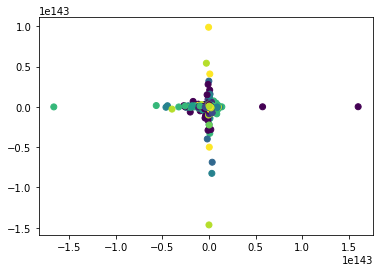

In [212]:
plt.scatter(res[:,0], res[:,1], c=y_train)

# Mnist 70k - root N

## step 1 - sample $\sqrt{N}$

In [160]:
N = X_train.shape[0]
# rootN = np.int(np.sqrt(N))
rootN = np.max((np.int(np.sqrt(N)), 1000))

In [161]:
rootN_ids = np.random.choice(N, size=rootN, replace=False)

In [162]:
rootN_data = X_train[rootN_ids]

## step 2 - force-based layout

In [163]:
pca = PCA(n_components=2).fit_transform(rootN_data)

In [164]:
from sklearn import preprocessing
pca = preprocessing.scale(pca)

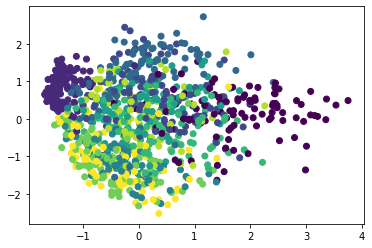

In [165]:
plt.scatter(pca[:,0], pca[:,1], c=y_train[rootN_ids], rasterized=True)

In [166]:
pdist = Distances(rootN_data)

In [167]:
fe = ForceEmbedding(pca, pdist)

In [168]:
fe.stress()

997658.4953889515

In [169]:
%time res = fe.optimize(1000)

CPU times: user 3min 30s, sys: 8.69 s, total: 3min 39s
Wall time: 54.8 s


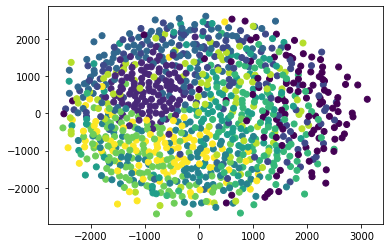

In [170]:
plt.scatter(res[:,0], res[:,1], c=y_train[rootN_ids], rasterized=True)

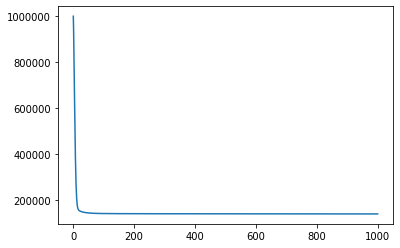

In [171]:
plt.plot(np.array(fe.error))

In [89]:
fe.force()

ForceEmbedding([[ 0.04045535,  0.05344551],
                [-0.14471351,  0.01763868],
                [ 0.08635821, -0.00879637],
                ...,
                [ 0.09023601, -0.08652832],
                [-0.08570753,  0.12967571],
                [-0.14095962, -0.00280975]])

In [172]:
from openTSNE import TSNE

In [173]:
res_tsne = []
tsne = TSNE(n_jobs=8,
            initialization='pca',
            callbacks=lambda it, err, emb: res_tsne.append((it, err)),
            callbacks_every_iters=1,
           )

In [174]:
%time embd_tsne = tsne.fit(rootN_data)

/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/pyforce/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 38:
    @numba.njit(parallel=True, fastmath=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anac

CPU times: user 3min 47s, sys: 13.7 s, total: 4min
Wall time: 33.9 s


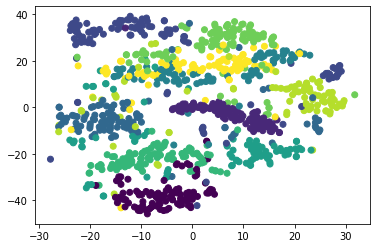

In [175]:
fig, ax = plt.subplots()
ax.scatter(embd_tsne[:,0], embd_tsne[:,1], c=y_train[rootN_ids], rasterized=True)

In [176]:
fe_tsne = ForceEmbedding(embd_tsne, pdist)

In [177]:
fe_tsne.stress()

974436.9005773329

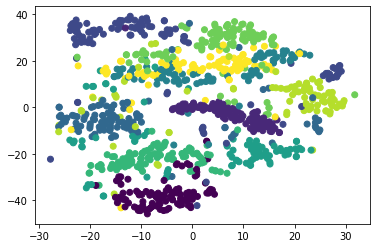

In [181]:
plt.scatter(fe_tsne[:,0], fe_tsne[:,1], c=y_train[rootN_ids], rasterized=True)

In [180]:
fe_tsne[:,0].shape

(1000,)

In [ ]:
fe.force()

In [ ]:
plt.hist(res.d_ij.ravel())

In [ ]:
from sklearn import preprocessing
res = preprocessing.scale(fe.d_ij, with_mean=False)

In [ ]:
plt.hist(res.ravel())

In [ ]:
pdist = ss.distance.pdist(self, 'euclidean')
e_ij_2 = ss.distance.squareform(pdist)

# https://stackoverflow.com/questions/32415061/
a = self[:, None, :]
e_ij_1 = (a - a.swapaxes(0,1))


F_ij_2 = (e_ij_2 - self.d_ij) / (e_ij_2 + np.finfo(float).eps)
# https://stackoverflow.com/questions/39026173/
F_ij = F_ij_2[:,:,None] * e_ij_1

F_i = np.sum(F_ij, axis=1)
return F_i

In [ ]:
pdist = ss.distance.pdist(fe, 'euclidean')
e_ij_2 = ss.distance.squareform(pdist)

In [ ]:
e_ij_2

In [ ]:
a = fe[:, None, :]
e_ij_1 = (a - a.swapaxes(0,1))

In [ ]:
e_ij_1

In [ ]:
F_ij_2 = (e_ij_2 - fe.d_ij) / (e_ij_2 + np.finfo(float).eps)

In [ ]:
F_ij_2

In [ ]:
F_ij = F_ij_2[:,:,None] * e_ij_1

In [ ]:
F_ij

In [ ]:
F_i = np.sum(F_ij, axis=1)

In [ ]:
F_i

In [ ]:
A = np.arange(9).reshape((3,3))

In [ ]:
A

In [ ]:
1./(A**2+np.finfo(float).eps)

# compute cost gradient

The expression for the stress to optimise is:

$stress(X) = \sum_{i<j}w_{ij}(||X_i - X_j|| - d_{ij})^2$

with:

$w_{ij} = d_{ij}^{-2}$

The update rule is to take the gradient and substract it.

In [ ]:
import autograd

In [ ]:
from autograd import grad

In [ ]:
def stress(X):
    pdist = ss.distance.pdist(X)
    res = np.sum((pdist - d_ij)**2 / d_ij)
    return res

In [ ]:
grad_stress = grad(stress)

In [ ]:
emb = np.random.random((X_train.shape[0], 2))

In [ ]:
pdist = ss.distance.pdist(emb)

In [ ]:
grad = grad_stress(pdist)

In [ ]:
plt.plot(grad)